In [2]:
import pandas as pd
import numpy as np

#Data
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split

#Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#Measures
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score

#Plots
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import matplotlib
font = {'family' : 'Times New Roman',
        'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
dataset = pd.read_csv('dataset/kc_house_data.csv')
dataset.drop(['id', 'date'],axis=1,inplace=True)
y_class = 'price'
dataset[y_class] = np.where(dataset[y_class] <= 4.5e+05, 0, 1)
X = dataset.drop([y_class],axis=1)
y = dataset[y_class]
dataset_name='kc_house_data'

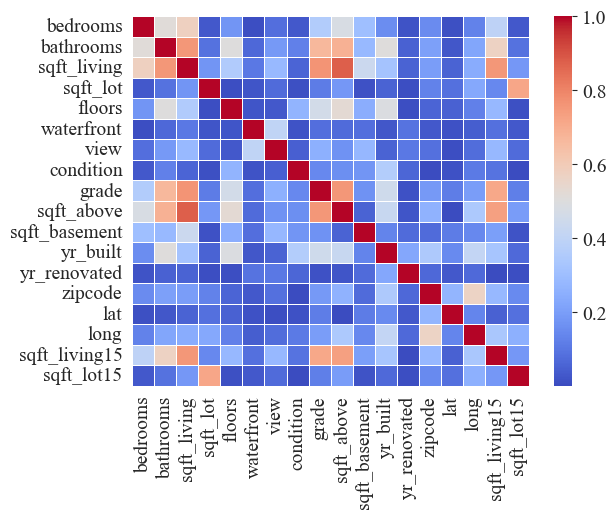

In [4]:
sns.heatmap(abs(X.corr()), annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.savefig(f'plots/heatmap_{dataset_name}.svg', format='svg')

In [8]:
dataset = pd.read_csv('dataset/cruise_ship_info.csv')
#dataset['crew'] = pd.cut(x = dataset['crew'],bins=2, labels=[0,1])
y_class = 'crew'
dataset.drop(['Ship_name','Cruise_line'],axis=1, inplace=True)

dataset[y_class] = np.where(dataset[y_class] <= 8.15, 0, 1)
X = dataset.drop(['crew'],axis=1)
y = dataset['crew']
dataset_name = 'cruise_ship'

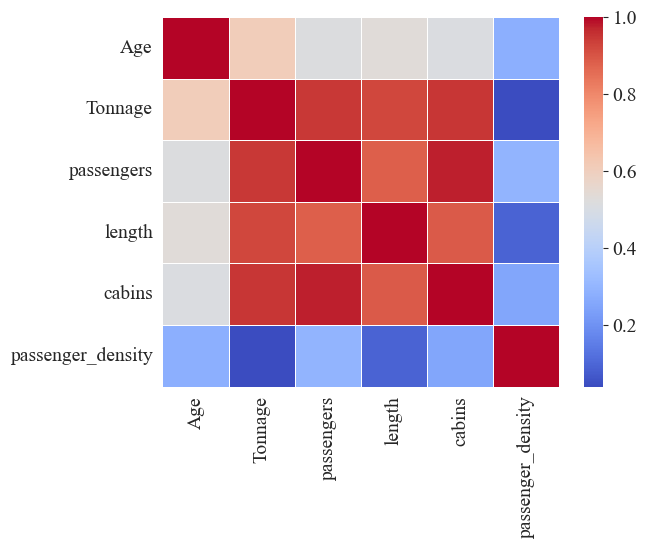

In [9]:
sns.heatmap(abs(X.corr()), annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.savefig(f'plots/heatmap_{dataset_name}.svg', format='svg')

In [12]:
dataset = pd.read_csv('dataset/customer_churn.csv').sample(frac=1).reset_index(drop=True)
dataset.replace({'no':0,'yes':1,
                 'area_code_408':0,
                 'area_code_415':1,
                 'area_code_510':2},inplace=True)
dataset.drop(['state'],axis=1, inplace=True)
X = dataset.drop(['churn'],axis=1)
y_class = 'churn'
y = dataset['churn']
dataset_name = 'customer_churn'

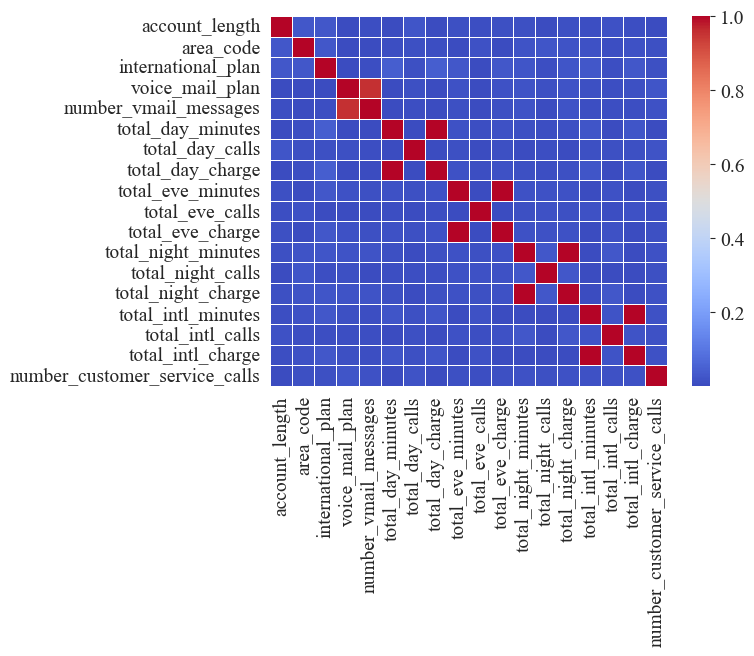

In [13]:
sns.heatmap(abs(X.corr()), annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.savefig(f'plots/heatmap_{dataset_name}.svg', format='svg')

In [14]:
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}
classifier_names = list(classifiers.keys())
measure_steps = [0, 1,2,3,4]
n_steps = len(measure_steps)
metrics = {
    'Accuracy': np.zeros((len(classifiers), n_steps)),
    'Precision': np.zeros((len(classifiers), n_steps)),
    'Recall': np.zeros((len(classifiers), n_steps)),
    'F1 Score': np.zeros((len(classifiers), n_steps))
}

In [15]:
dataset_new = dataset.copy()
train, test = train_test_split(dataset_new, test_size=0.3, random_state=42)
X_test = test.drop([y_class],axis=1)
y_test = test[y_class]
X_train_new = train.copy()

for i, step in enumerate(measure_steps):

    y_train = train[y_class]
    X_train = train.drop([y_class],axis=1)

    if i != 0:
        to_drop = (abs(X_train_new.corr()) * (1-np.eye(X_train_new.shape[1]))).unstack().sort_values(ascending=False).index[0][0]
        X_train_new = X_train_new.drop(to_drop,axis=1)
    '''
    X,y = make_classification(
                    n_samples=10000,
                    n_features=20,
                    n_redundant=10-i,
                    random_state=42
                )
    '''
    #X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)
    for j, (classifier_name, classifier) in enumerate(classifiers.items()):
            #num_folds=5
            #kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
            #scaler = StandardScaler()
            #X_scaled = scaler.fit_transform(X)
            #predictions = cross_val_predict(classifier, X_scaled, y, cv=kf)


            # Standardize the features (optional but often recommended)
            scaler = StandardScaler()
            train_X_scaled = scaler.fit_transform(X_train)
            test_X_scaled = scaler.transform(X_test)
            # Train the classifier
            classifier.fit(train_X_scaled, y_train)
            # Make predictions on the fixed test set
            predictions = classifier.predict(test_X_scaled)

            # Calculate metrics and store in the metrics dictionary
            metrics['Accuracy'][j, i] = balanced_accuracy_score(y_test, predictions)
            metrics['Precision'][j, i] = precision_score(y_test, predictions, average='weighted')
            metrics['Recall'][j, i] = recall_score(y_test, predictions, average='weighted')
            metrics['F1 Score'][j, i] = f1_score(y_test, predictions, average='weighted')

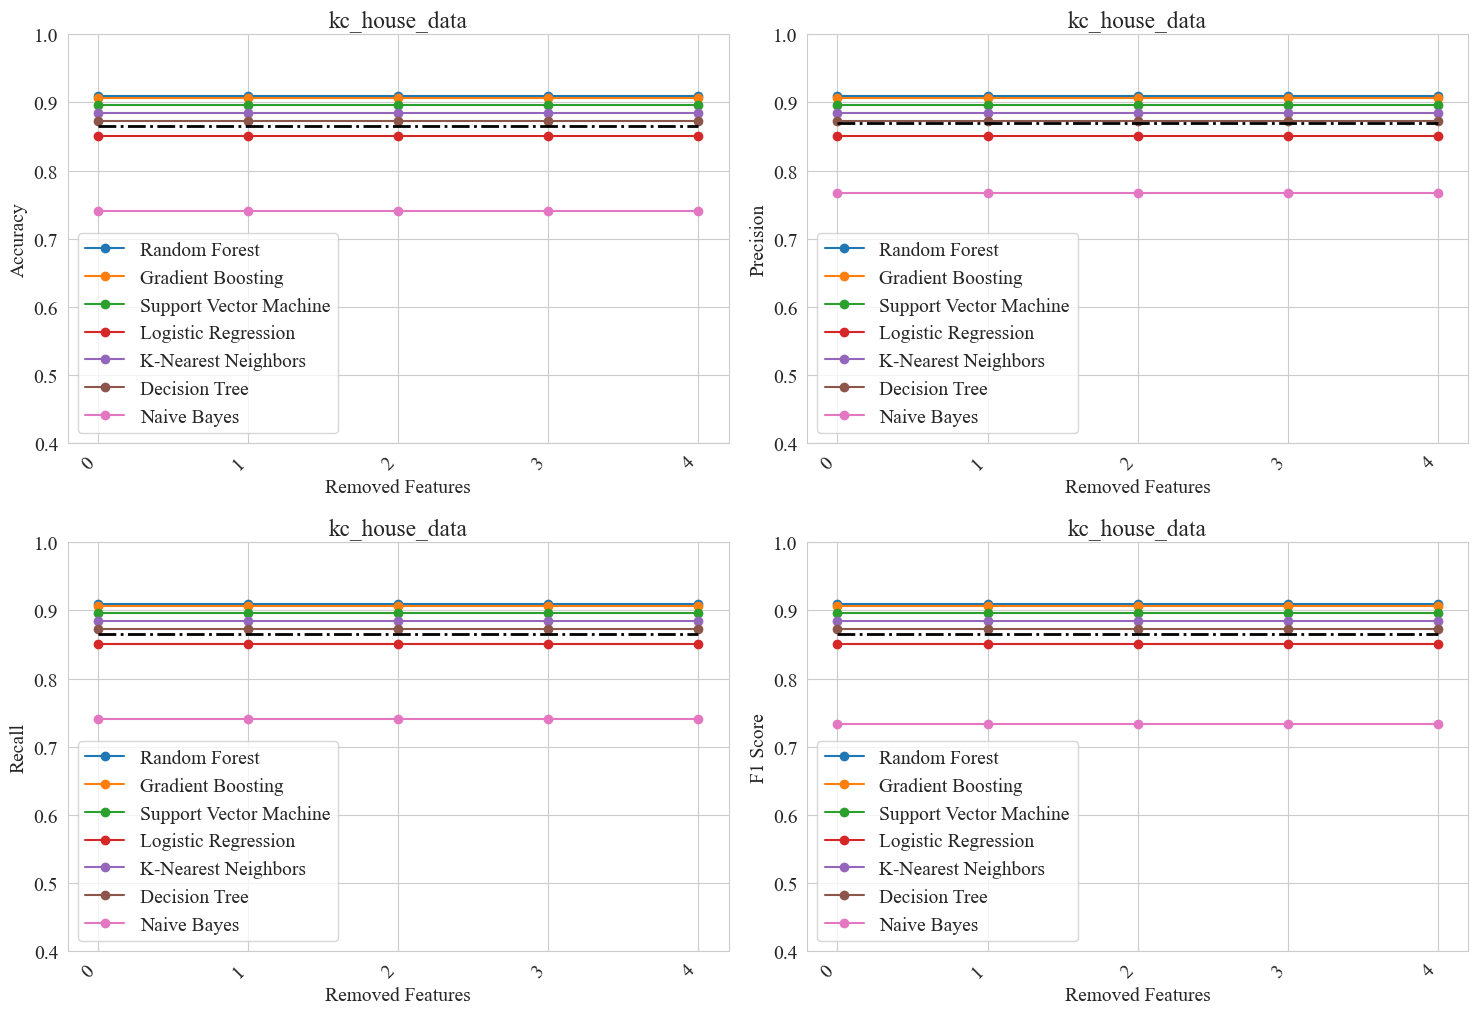

In [7]:
plt.figure(figsize=(15, 20))
for k, metric in metrics.items():
    plt.subplot(4, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_steps, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel('Removed Features')
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_steps, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/features_dependency_{dataset_name}.svg', format='svg')
plt.show()

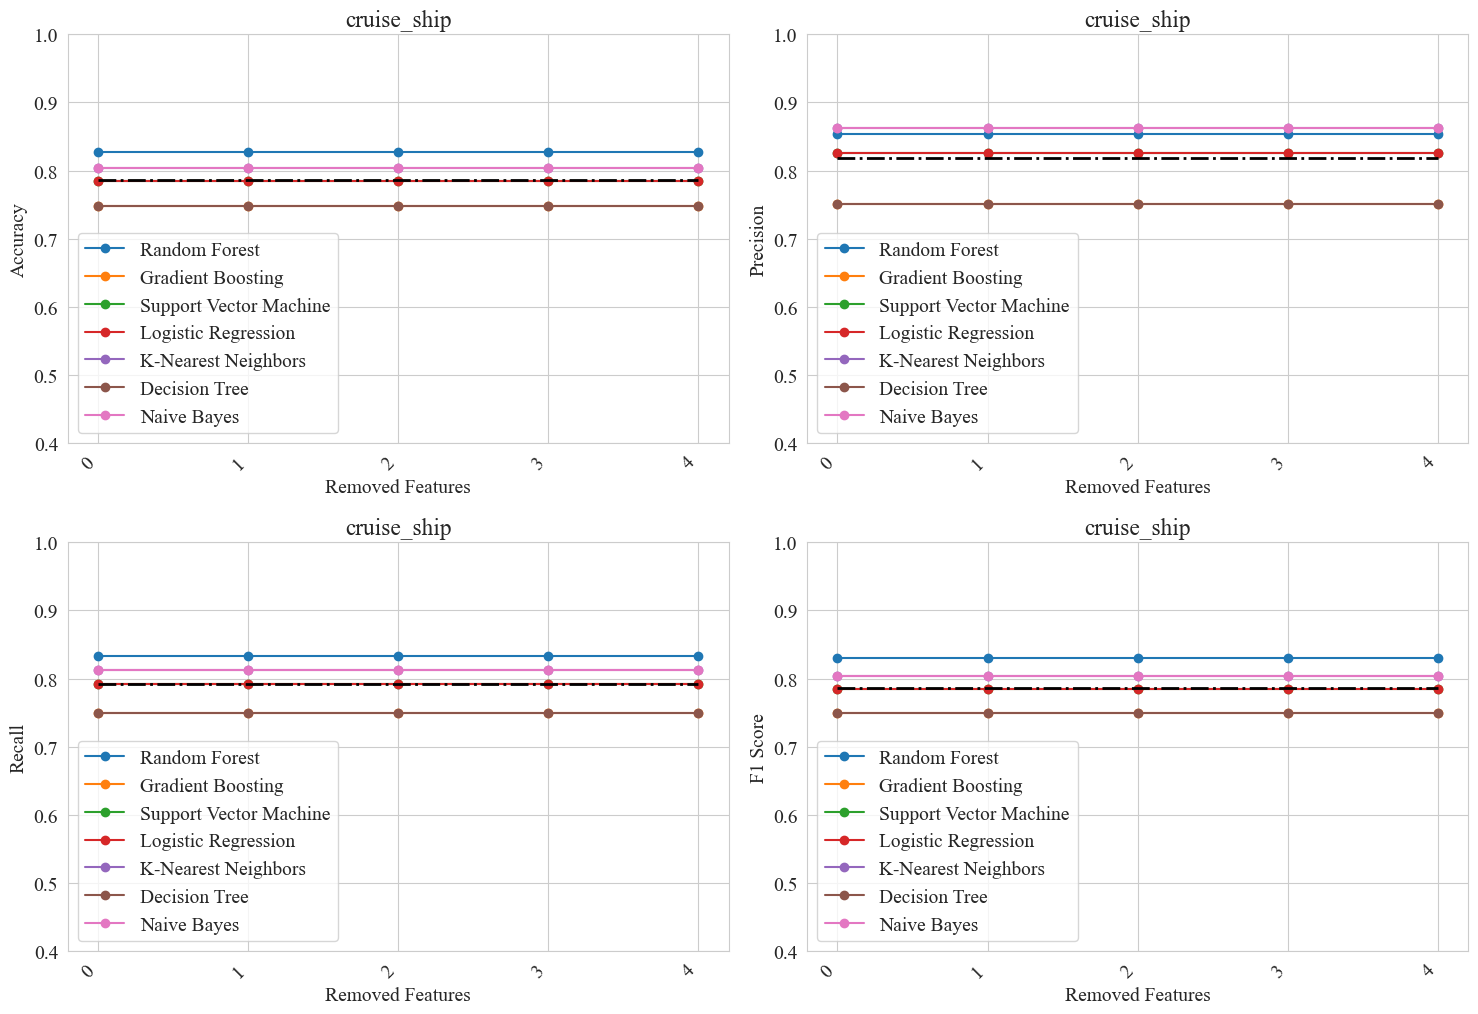

In [11]:
plt.figure(figsize=(15, 20))
for k, metric in metrics.items():
    plt.subplot(4, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_steps, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel('Removed Features')
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_steps, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/features_dependency_{dataset_name}.svg', format='svg')
plt.show()


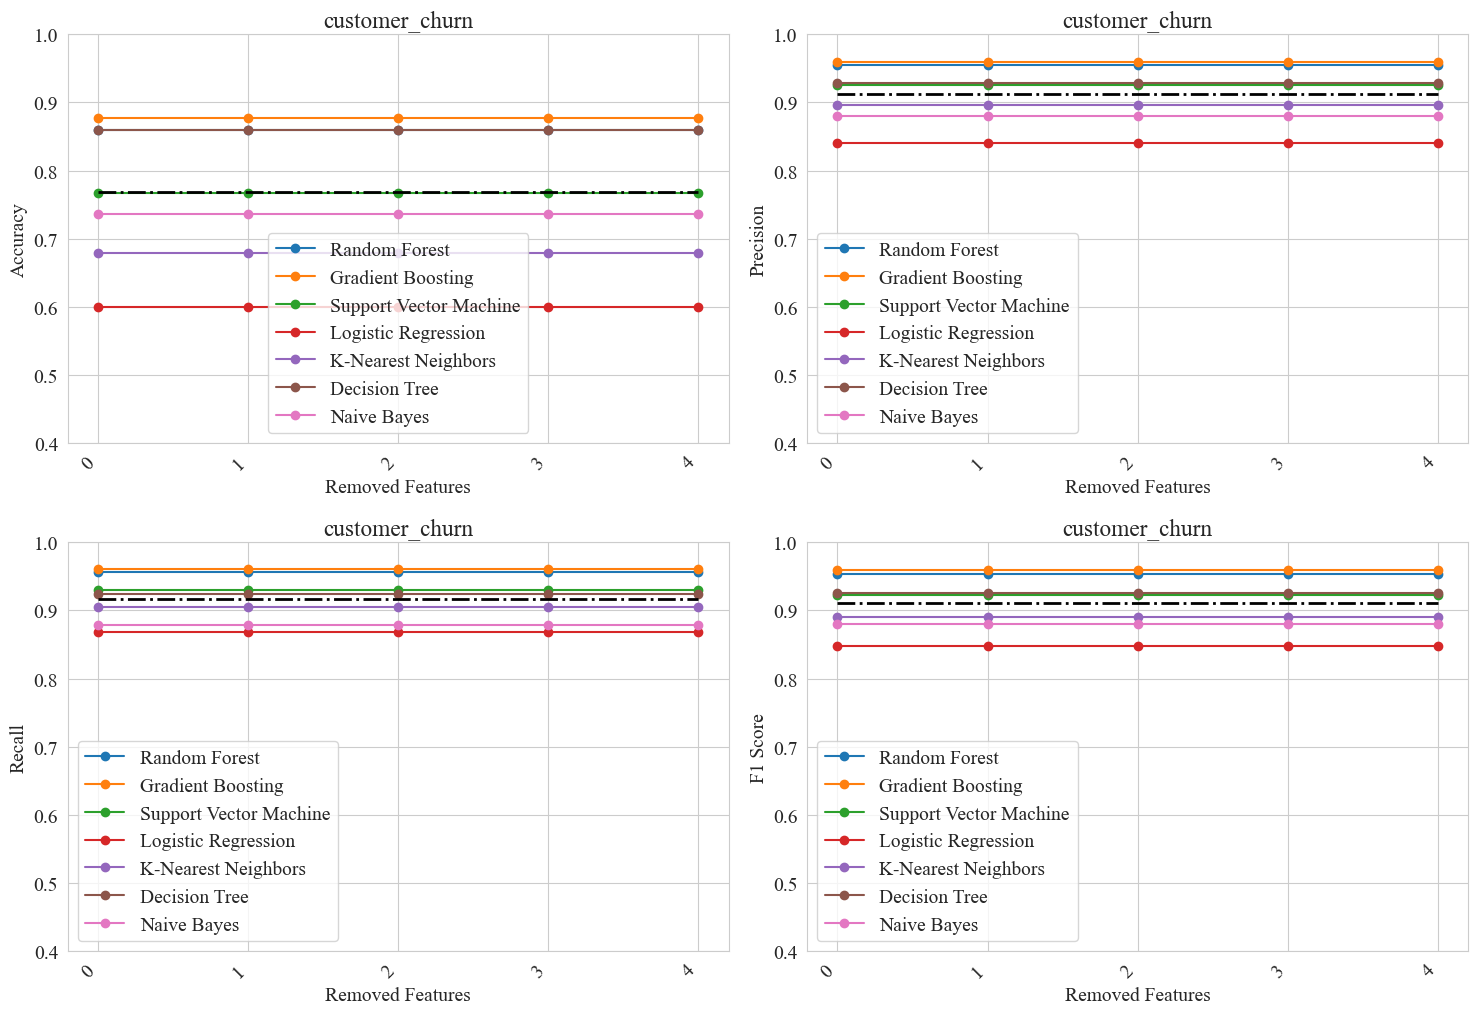

In [16]:
plt.figure(figsize=(15, 20))
for k, metric in metrics.items():
    plt.subplot(4, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_steps, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel('Removed Features')
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_steps, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/features_dependency_{dataset_name}.svg', format='svg')
plt.show()


In [17]:
dataset_name = 'synthetic_dataset'

for i, step in enumerate(measure_steps):

    X,y = make_classification(
                    n_samples=10000,
                    n_features=20,
                    n_redundant=10-i,
                    random_state=42
                )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    for j, (classifier_name, classifier) in enumerate(classifiers.items()):
            #num_folds=5
            #kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
            #scaler = StandardScaler()
            #X_scaled = scaler.fit_transform(X)
            #predictions = cross_val_predict(classifier, X_scaled, y, cv=kf)


            # Standardize the features (optional but often recommended)
            scaler = StandardScaler()
            train_X_scaled = scaler.fit_transform(X_train)
            test_X_scaled = scaler.transform(X_test)
            # Train the classifier
            classifier.fit(train_X_scaled, y_train)
            # Make predictions on the fixed test set
            predictions = classifier.predict(test_X_scaled)

            # Calculate metrics and store in the metrics dictionary
            metrics['Accuracy'][j, i] = balanced_accuracy_score(y_test, predictions)
            metrics['Precision'][j, i] = precision_score(y_test, predictions, average='weighted')
            metrics['Recall'][j, i] = recall_score(y_test, predictions, average='weighted')
            metrics['F1 Score'][j, i] = f1_score(y_test, predictions, average='weighted')

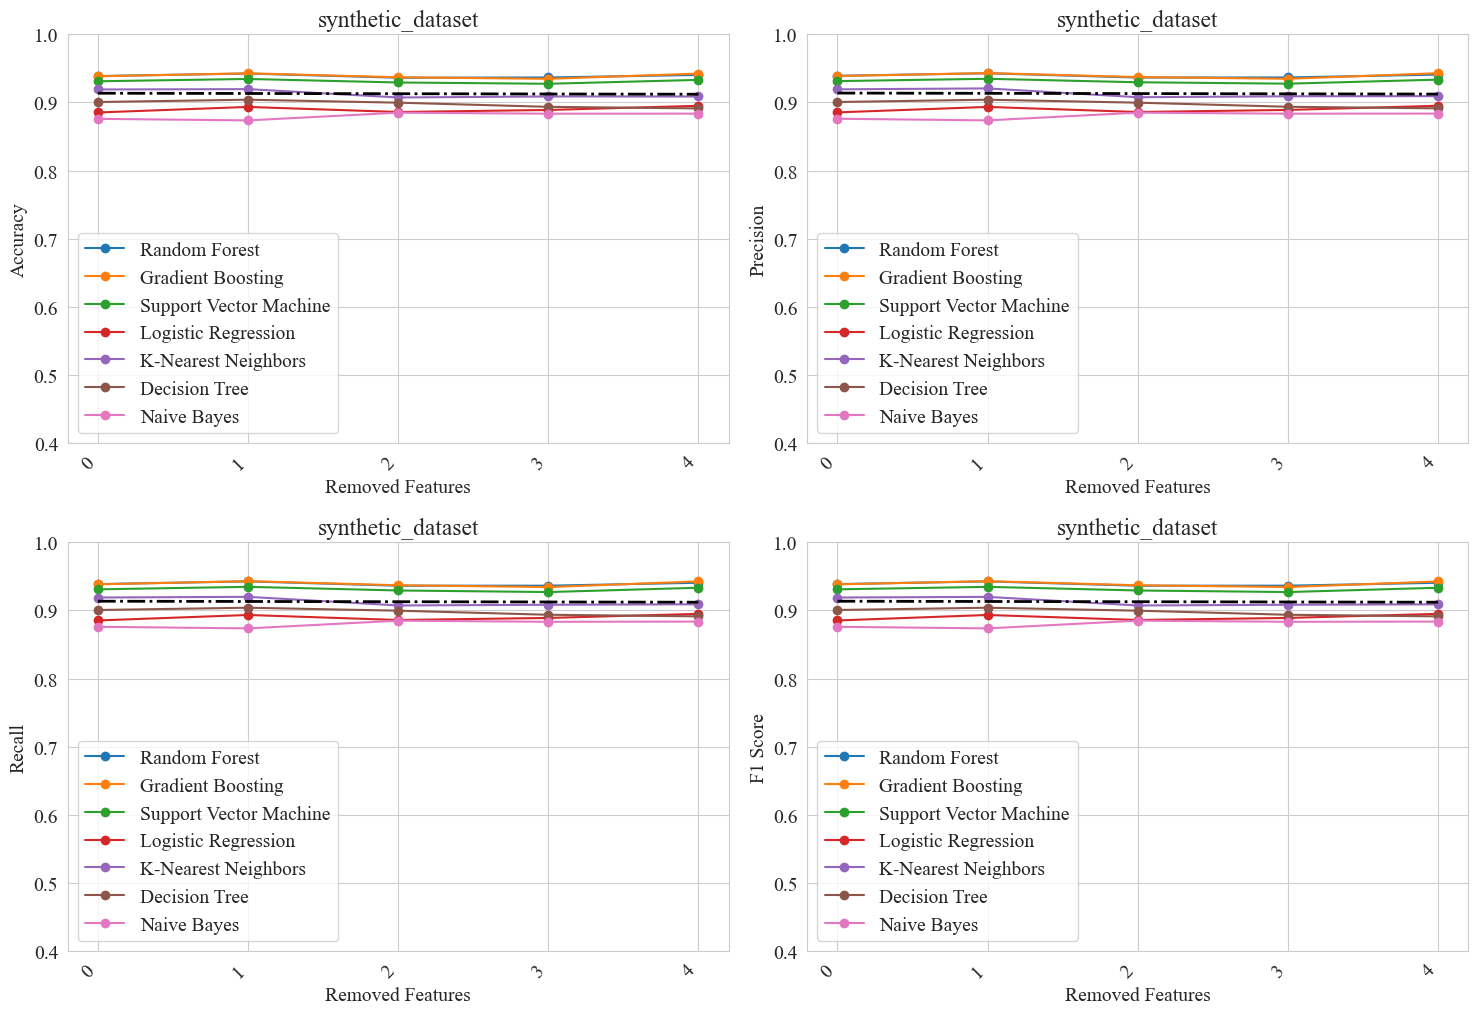

In [18]:
plt.figure(figsize=(15, 20))
for k, metric in metrics.items():
    plt.subplot(4, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_steps, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel('Removed Features')
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_steps, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/features_dependency_{dataset_name}.svg', format='svg')
plt.show()
